In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from datetime import datetime

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *

import pyspark.sql.functions as F

import initspark

In [2]:
spark = SparkSession.builder.appName("TaxiData").getOrCreate()

schema = StructType([
    StructField("date", StringType()),
    StructField("lat", DoubleType()),
    StructField("lon", DoubleType()),
    StructField("base", StringType())
])

csv = spark.read.option("header", "true").csv("./data/uber/*.csv", schema = schema)

In [3]:
f = udf(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"), TimestampType())
data = csv.withColumn("date", f(csv.date)).cache()

In [4]:
data.printSchema()
data.show()

root
 |-- date: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)

+--------------------+-------+--------+------+
|                date|    lat|     lon|  base|
+--------------------+-------+--------+------+
|2014-09-01 00:01:...|40.2201|-74.0021|B02512|
|2014-09-01 00:01:...|  40.75|-74.0027|B02512|
|2014-09-01 00:03:...|40.7559|-73.9864|B02512|
|2014-09-01 00:06:...| 40.745|-73.9889|B02512|
|2014-09-01 00:11:...|40.8145|-73.9444|B02512|
|2014-09-01 00:12:...|40.6735|-73.9918|B02512|
|2014-09-01 00:15:...|40.7471|-73.6472|B02512|
|2014-09-01 00:16:...|40.6613|-74.2691|B02512|
|2014-09-01 00:32:...|40.3745|-73.9999|B02512|
|2014-09-01 00:33:...|40.7633|-73.9773|B02512|
|2014-09-01 00:33:...|40.7467|-73.6131|B02512|
|2014-09-01 00:37:...|40.8105|  -73.96|B02512|
|2014-09-01 00:38:...| 40.679|-74.0111|B02512|
|2014-09-01 00:39:...|40.4023|-73.9839|B02512|
|2014-09-01 00:48:...|40.7378|-74.0395|B02512|
|20

In [5]:
# 40.66704, -73.83396
# 40.90366, -74.10665

In [6]:
dataFiltered = data\
    .where(data.lat > 40.66704)\
    .where(data.lat < 40.90366)\
    .where(data.lon < -73.83396)\
    .where(data.lon > -74.10665)\
    .cache()

In [7]:
print(data.count())
print(dataFiltered.count())

4534327
4236494


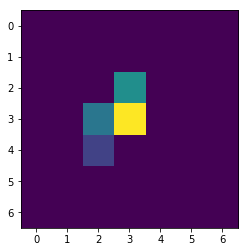

In [9]:
rawImage = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 126, 0, 0, 0],
    [0, 0, 100, 255, 0, 0, 0],
    [0, 0, 50, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
]

plt.imshow(rawImage)
plt.show()

In [10]:
# Rechts unten: 40.66704, -73.83396
# Links oben: 40.90366, -74.10665

# 40.90366, -74.10665 => [0][0]
# 40.66704, -73.83396 => [6][6]
# 40.80000, -73.95000 => [3][3]

In [11]:
value = 40.80000

value2 = (value - 40.66704) / (40.90366 - 40.66704)
print(round(value2 * 7))

4


In [13]:
size = 1000
dataFiltered\
    .select(
        F.round(((dataFiltered.lat - 40.66704) / (40.90366 - 40.66704)) * size),
        F.round(((dataFiltered.lon + 73.83396) / (-74.10665 + 73.83396)) * size),
        F.date_format(dataFiltered.date, "E")
    )\
    .withColumnRenamed(
        "round((((lat - 40.66704) / 0.23662000000000205) * " + str(size) + "), 0)", 
        "lat"
    )\
    .withColumnRenamed(
        "round((((lon + 73.83396) / -0.2726899999999972) * " + str(size) + "), 0)", 
        "lon"
    )\
    .withColumnRenamed(
        "date_format(date, E)", 
        "day"
    )\
    .groupBy("lat", "lon", "day")\
    .count()\
    .show()

+-----+-----+---+-----+
|  lat|  lon|day|count|
+-----+-----+---+-----+
|387.0|212.0|Mo.|    1|
|455.0|575.0|Mo.|    6|
|357.0|586.0|Mo.|  209|
|223.0|471.0|Mo.|   20|
|272.0|646.0|Di.|   53|
|249.0|641.0|Di.|   10|
|387.0|541.0|Di.|  104|
|210.0|429.0|Di.|    3|
|536.0|514.0|Di.|    7|
|279.0|581.0|Do.|   31|
|366.0|576.0|Do.|   16|
|292.0|719.0|Fr.|    7|
|372.0|509.0|Fr.|   40|
|191.0|637.0|Fr.|    2|
|157.0|633.0|Fr.|   18|
|363.0|600.0|Fr.|    4|
|360.0|373.0|Fr.|   10|
|378.0|547.0|Fr.|   64|
|277.0|564.0|Sa.|  129|
|343.0|630.0|Sa.|   31|
+-----+-----+---+-----+
only showing top 20 rows



In [14]:
dataForImage = dataFiltered\
    .select(
        F.round(((dataFiltered.lat - 40.66704) / (40.90366 - 40.66704)) * size),
        F.round(((dataFiltered.lon + 73.83396) / (-74.10665 + 73.83396)) * size),
        F.date_format(dataFiltered.date, "E")
    )\
    .withColumnRenamed(
        "round((((lat - 40.66704) / 0.23662000000000205) * " + str(size) + "), 0)", 
        "lat"
    )\
    .withColumnRenamed(
        "round((((lon + 73.83396) / -0.2726899999999972) * " + str(size) + "), 0)", 
        "lon"
    )\
 .withColumnRenamed(
        "date_format(date, E)", 
        "day"
    )\
    .groupBy("lat", "lon", "day")\
    .count()\
    .collect()

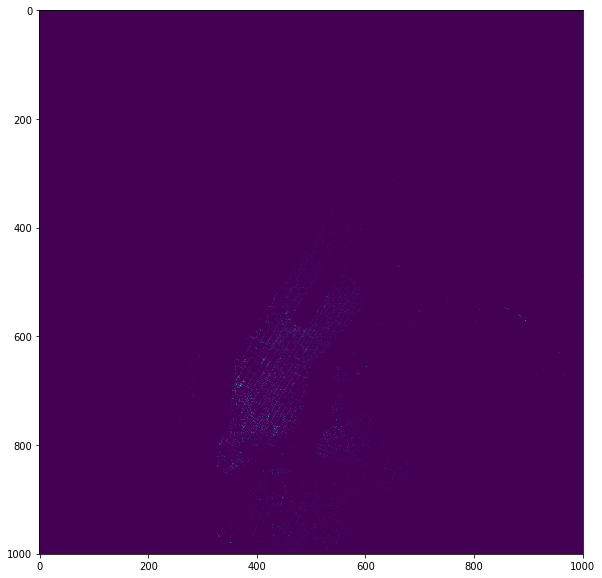

In [15]:
img = []
for i in range(0, size + 1):
    imgRow = []
    for j in range(0, size + 1):
        imgRow.append(0)
    img.append(imgRow)
    
for row in dataForImage:
    if row.day == "Sa.":
        img[size - int(row.lat)][size - int(row.lon)] = row["count"]

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [16]:
import math


In [17]:
math.log(2)

0.6931471805599453

In [18]:
math.log(20)

2.995732273553991

In [19]:
math.log(40)

3.6888794541139363

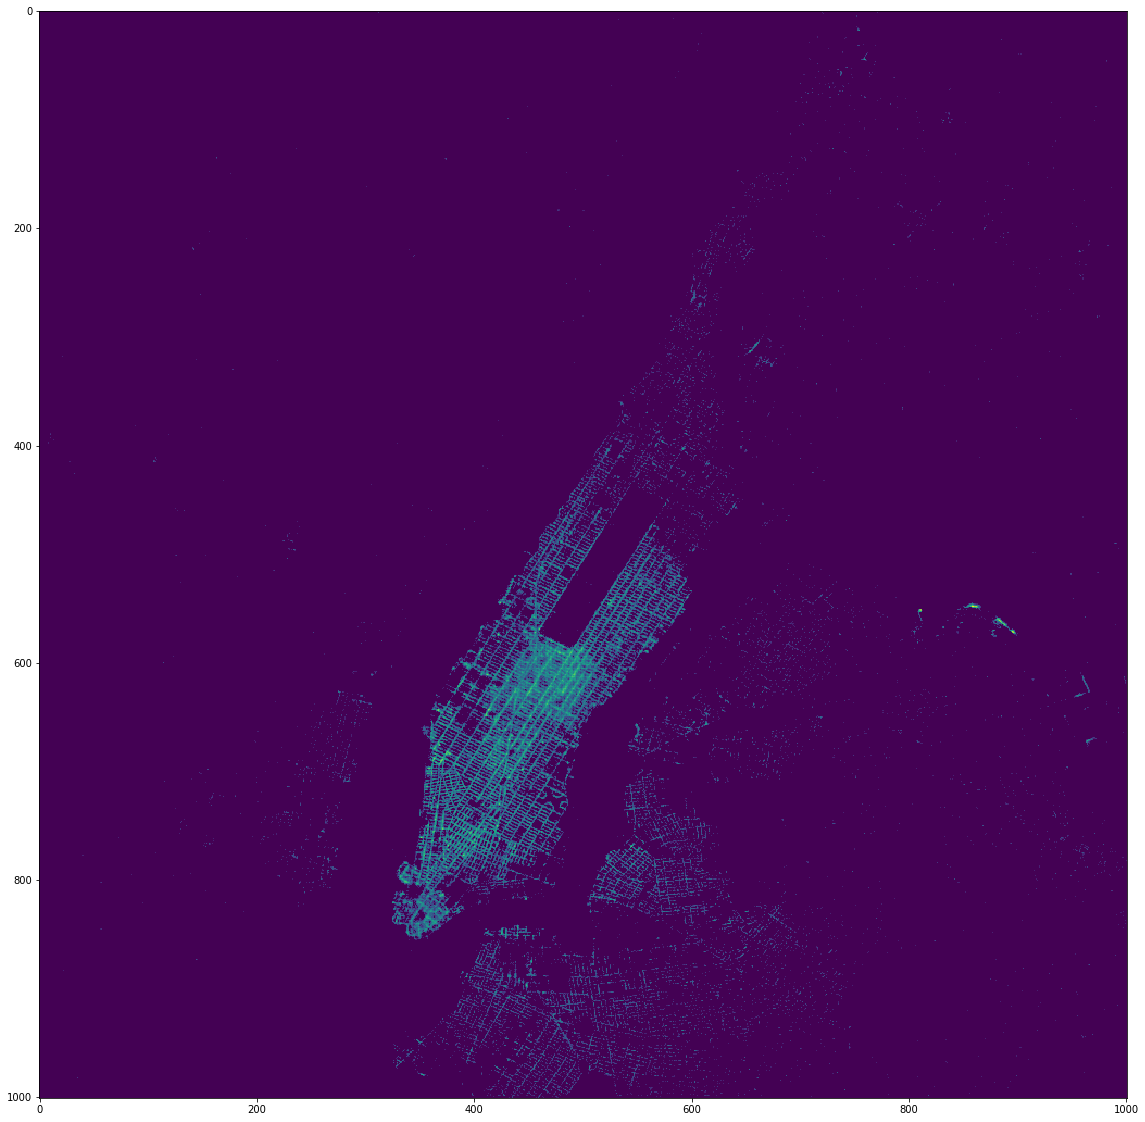

In [20]:
img = []
for i in range(0, size + 1):
    imgRow = []
    for j in range(0, size + 1):
        imgRow.append(0)
    img.append(imgRow)
    
for row in dataForImage:
    if row.day == "Di.":
        img[size - int(row.lat)][size - int(row.lon)] = math.log(row["count"])

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()